In [26]:
# ====================================
# Section 1: Synthetic Data Generation
# ====================================
# Install necessary tools
!pip install numpy pandas scikit-learn xgboost tensorflow keras prophet gym gymnasium boto3 stable-baselines3[extra] "shimmy>=2.0"

import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

np.random.seed(42)

# Configuration
num_days = 30
interval_minutes = 5
total_points = int((24 * 60 / interval_minutes) * num_days)  # ~2016 rows

# Generate timestamps
start_time = datetime(2024, 1, 1, 0, 0, 0)
timestamps = [start_time + timedelta(minutes=i * interval_minutes) for i in range(total_points)]

# === Predictable Bursty Invocations ===
def generate_bursty_invocations(n, base=100):
    invocations = []
    for i in range(n):
        # Inject burst every 50 steps (approx every 4.2 hrs)
        if i % 50 in range(5):  # 5-step burst duration
            val = base + 120 + np.random.normal(0, 10)
        else:
            val = base + np.sin(i / 10.0) * 25 + np.random.normal(0, 5)
        invocations.append(max(1, int(val)))
    return invocations

invocations = generate_bursty_invocations(total_points)

# Memory allocations
memory_choices = [128, 256, 512, 1024, 2048, 3008]
memory_MB = [random.choice(memory_choices) for _ in range(total_points)]

# Timeout (in seconds): AWS Lambda typical range
timeout_sec = [random.choice([1, 3, 5, 10, 15, 30]) for _ in range(total_points)]

# Concurrency estimate (inferred from invocation rate)
concurrency = [max(1, int(inv / 10)) for inv in invocations]

# Cold start (10% probability)
cold_start = [1 if random.random() < 0.1 else 0 for _ in range(total_points)]

# Duration (ms): base duration affected by load
duration_ms = [round(random.gauss(100 + inv / 3, 15), 2) for inv in invocations]

# Latency (ms): base + cold start penalty + noise
latency_ms = [
    round(d + (150 if cs else 20) + np.random.normal(0, 10), 2)
    for d, cs in zip(duration_ms, cold_start)
]

# Create DataFrame
df = pd.DataFrame({
    "timestamp": timestamps,
    "invocations": invocations,
    "memory_MB": memory_MB,
    "timeout_sec": timeout_sec,
    "concurrency": concurrency,
    "cold_start": cold_start,
    "latency_ms": latency_ms,
    "duration_ms": duration_ms,
})

# Timestamp feature engineering
df["hour"] = df["timestamp"].dt.hour
df["minute"] = df["timestamp"].dt.minute
df["second"] = df["timestamp"].dt.second
df["dayofweek"] = df["timestamp"].dt.dayofweek

# Lag features
df["invocations_lag1"] = df["invocations"].shift(1)
df["invocations_lag2"] = df["invocations"].shift(2)
df["invocations_avg_5"] = df["invocations"].rolling(window=5).mean()
df["invocations_std_5"] = df["invocations"].rolling(window=5).std()

# Drop initial NaN rows
df = df.dropna().reset_index(drop=True)

# Export
df.to_csv("synthetic_invocations.csv", index=False)
print(df.head())


            timestamp  invocations  memory_MB  timeout_sec  concurrency  \
0 2024-01-01 00:20:00          217        512            3           21   
1 2024-01-01 00:25:00          110        256           15           11   
2 2024-01-01 00:30:00          122        256            3           12   
3 2024-01-01 00:35:00          119        256           15           11   
4 2024-01-01 00:40:00          115       3008            1           11   

   cold_start  latency_ms  duration_ms  hour  minute  second  dayofweek  \
0           1      338.17       185.65     0      20       0          0   
1           0      140.33       140.03     0      25       0          0   
2           0      142.51       144.54     0      30       0          0   
3           0      157.72       139.93     0      35       0          0   
4           1      281.91       129.44     0      40       0          0   

   invocations_lag1  invocations_lag2  invocations_avg_5  invocations_std_5  
0             235.0 

In [16]:
# =========================================================
# Section 2: Optimized Forecast with XGBoost + GridSearchCV
# =========================================================

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Time-based features
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# --- Lag-based features
df["invocations_lag1"] = df["invocations"].shift(1)
df["invocations_lag2"] = df["invocations"].shift(2)
df["invocations_avg_5"] = df["invocations"].rolling(window=5).mean()
df["invocations_std_5"] = df["invocations"].rolling(window=5).std()

# --- Drop NA values from lag features
df = df.dropna().reset_index(drop=True)

# --- Feature selection
features = [
    'hour', 'dayofweek', 'is_weekend',
    'invocations_lag1', 'invocations_lag2',
    'invocations_avg_5', 'invocations_std_5'
]
target = 'invocations'

X = df[features]
y = df[target]

# --- Time-aware train/test split
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# --- Grid search parameter space
param_grid = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 5]
}

grid = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

# --- Fit the grid search
grid.fit(X_train, y_train)

# --- Use the best model
best_model = grid.best_estimator_
print(f"Best Params: {grid.best_params_}")


Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


MAE: 9.48
RMSE: 19.61
R² Score: 0.76


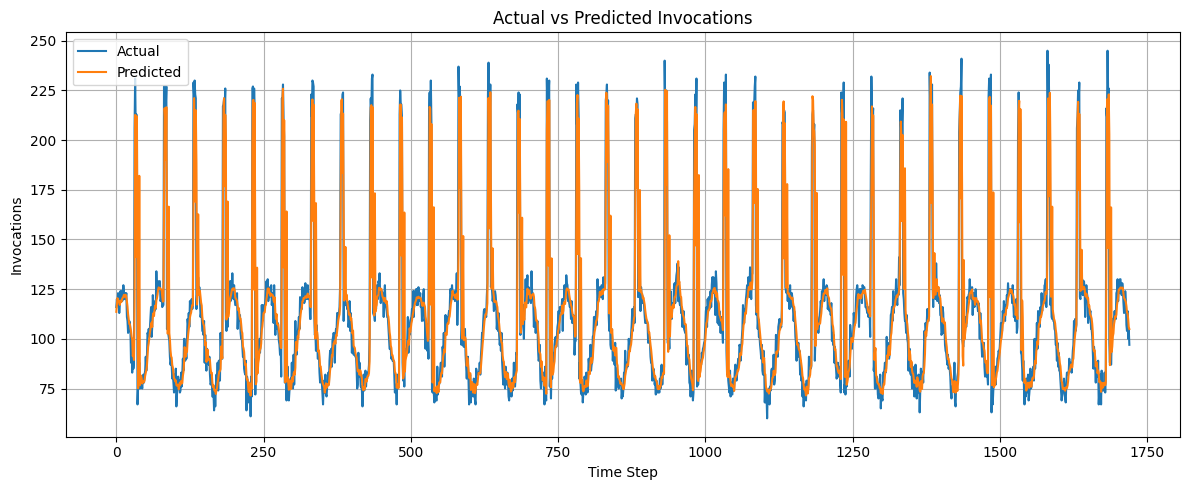

In [17]:
#Save the best model for re-producitivity.
import joblib

# Save to disk
joblib.dump(best_model, "xgb_best_model.pkl")

# Load it back:
loaded_model = joblib.load("xgb_best_model.pkl")

# Verify it gives the same predictions
y_pred_loaded = loaded_model.predict(X_test)
assert np.allclose(y_pred_loaded, best_model.predict(X_test))

# --- Evaluate on test set
y_pred = loaded_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# --- Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted Invocations")
plt.xlabel("Time Step")
plt.ylabel("Invocations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Generate forecast for RL use
forecast_df = df.copy()
forecast_df['forecast'] = best_model.predict(X)
forecast_series = forecast_df['forecast'].tolist()


In [27]:
# =======================================
# Section 3: Custom Gymnasium Environment
# =======================================

import numpy as np
import gymnasium as gym
from gymnasium import spaces

class ServerlessTuningEnv(gym.Env):
    """
    A custom Gymnasium environment for tuning serverless function configurations.
    """

    def __init__(self, forecast_sequence):
        """
        Initialize the tuning environment.
        """
        super(ServerlessTuningEnv, self).__init__()
        # Forecast series and step counters
        self.forecast_sequence = forecast_sequence
        self.current_step = 0
        self.max_steps = len(self.forecast_sequence)
        self.max_forecast = max(self.forecast_sequence)

        # Discrete action options
        self.memory_options = [128, 256, 512, 1024]
        self.timeout_options = [3, 5, 10]
        self.concurrency_options = [1, 2, 3]

        # Combined action space size
        self.action_space = spaces.Discrete(
            len(self.memory_options) *
            len(self.timeout_options) *
            len(self.concurrency_options)
        )

        # Observation: [normalized_forecast, normalized_latency, normalized_cost]
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)
        self.state = None

    def _decode_action(self, action):
        """
        Decode a single integer action into memory, timeout, and concurrency settings.
        """
        m_idx = action // (len(self.timeout_options) * len(self.concurrency_options))
        t_idx = (action // len(self.concurrency_options)) % len(self.timeout_options)
        c_idx = action % len(self.concurrency_options)
        return (self.memory_options[m_idx],
                self.timeout_options[t_idx],
                self.concurrency_options[c_idx])

    def reset(self, *, seed=None, options=None):
        """
        Reset the environment state to start a new episode.
        """
        super().reset(seed=seed)
        self.current_step = 0
        # Initialize with neutral midpoints
        self.state = np.array([0.5, 0.5, 0.5], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        """
        Execute one time-step of the environment based on the agent's action.
        """
        # End episode if forecast exhausted
        if self.current_step >= self.max_steps:
            return self.state, 0.0, True, False, {}

        # Retrieve forecast and normalize
        forecast = self.forecast_sequence[self.current_step]
        normalized_forecast = forecast / self.max_forecast

        # Decode chosen configuration
        memory, timeout, concurrency = self._decode_action(action)

        # === Latency Calculation ===
        # Base latency minus savings from concurrency + added load impact
        latency = max(50, 250 - concurrency * 50 - memory * 0.2 + normalized_forecast * 120)

        # === Cost Calculation ===
        # Simple cost model: cost ∝ memory × timeout × concurrency × invocations
        invocations_per_step = 200
        cost = memory * 0.00001667 * (timeout / 60) * concurrency * invocations_per_step

        # === SLA Violation Check ===
        sla_threshold = 200
        sla_violated = latency > sla_threshold

        # === Reward Function (Latency-Focused, Balanced Cost, Soft SLA Penalty) ===
        latency_penalty = (latency / 200) ** 2
        cost_penalty = cost * (50 if normalized_forecast >= 0.5 else 30)
        sla_penalty = 2 if sla_violated else 0

        reward = - (latency_penalty + cost_penalty + sla_penalty)

        # Efficiency bonus for low-latency, low-cost settings
        if latency < 170 and cost < 0.002:
            reward += 0.4

        # Penalize overprovisioning when load is light
        if normalized_forecast < 0.3:
            if memory > 512:
                reward -= 0.2
            if concurrency > 1:
                reward -= 0.2

        # --- State Update ---
        normalized_latency = min(latency / 300, 1.0)
        normalized_cost = min(cost / 0.1, 1.0)

        self.state = np.array([
            normalized_forecast,
            normalized_latency,
            normalized_cost
        ], dtype=np.float32)

        # Advance to next time step
        self.current_step += 1
        done = self.current_step >= self.max_steps

        # Return observation, reward, and diagnostics
        info = {
            "latency": latency,
            "cost": cost,
            "sla_violated": sla_violated
        }

        return self.state, reward, done, False, info


In [43]:
# =================================================
# Section 4: A2C Agent – Training with Dual Penalty
# =================================================

from stable_baselines3 import A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv

# Wrap the custom env in a vectorized interface
env = DummyVecEnv([lambda: ServerlessTuningEnv(forecast_series)])

# Ensure the env follows Gym’s API
check_env(ServerlessTuningEnv(forecast_series), warn=True)

# Create the A2C agent with fixed hyperparameters
a2c_model = A2C(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0007,
    gamma=0.99,
    n_steps=64,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    seed=42
)

# Train for a set number of timesteps
a2c_model.learn(total_timesteps=11000)

# Save the trained model for later use
a2c_model.save("a2c_serverless_model")
print("A2C training completed with dual-penalty reward and saved as 'a2c_serverless_model.zip'")


Using cpu device
-------------------------------------
| time/                 |           |
|    fps                | 214       |
|    iterations         | 100       |
|    time_elapsed       | 29        |
|    total_timesteps    | 6400      |
| train/                |           |
|    entropy_loss       | -3.54     |
|    explained_variance | -0.000631 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -1.23e+03 |
|    value_loss         | 1.37e+05  |
-------------------------------------
A2C training completed with dual-penalty reward and saved as 'a2c_serverless_model.zip'


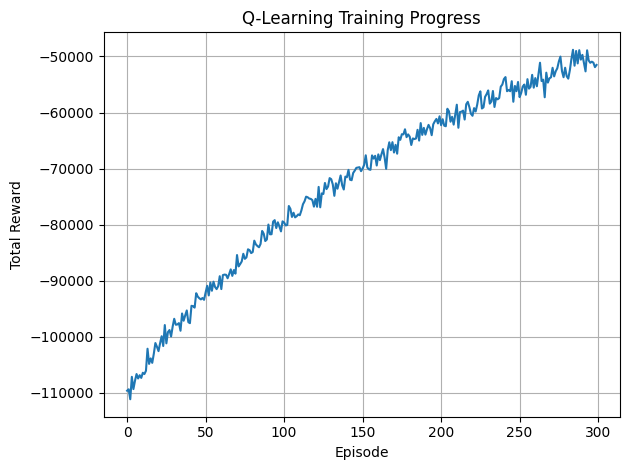

In [29]:
# ===============================================
# Section 5: Q-Learning Agent – Training and Plot
# ===============================================

import numpy as np
import matplotlib.pyplot as plt

# Define Q-Learning Agent
class QLearningAgent:
    """
    Simple Q-learning agent with epsilon-greedy policy and state discretization.
    """

    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.05):
        """ Initialize Q-learning parameters and empty Q-table. """
        np.random.seed(42)
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # discretize each of the 3 state features into equal bins
        self.state_bins = 10
        # Q-table: (num_discrete_states × num_actions)
        self.q_table = np.zeros((self.state_bins**3, env.action_space.n))

    def discretize_state(self, state):
        """
        Map continuous state to a single discrete index.
        Splits each feature into bins, then flattens to 1D index.
        """
        bins = np.linspace(0, 1, self.state_bins + 1)
        indices = [min(self.state_bins - 1, max(0, np.digitize(s, bins) - 1)) for s in state]
        return indices[0] * (self.state_bins**2) + indices[1] * self.state_bins + indices[2]

    def choose_action(self, state):
        """
        Select an action via ε-greedy:
        - with prob. ε, choose random action (explore)
        - otherwise, pick the best-known action (exploit)
        """
        state_idx = self.discretize_state(state)
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[state_idx])

    def update_q_value(self, state, action, reward, next_state):
        """
        Apply the Q-learning update rule:
        Q(s,a) ← Q(s,a) + α [r + γ max_a' Q(s',a') − Q(s,a)]
        """
        state_idx = self.discretize_state(state)
        next_state_idx = self.discretize_state(next_state)
        best_next_action = np.max(self.q_table[next_state_idx])
        td_target = reward + self.gamma * best_next_action
        td_error = td_target - self.q_table[state_idx][action]
        self.q_table[state_idx][action] += self.alpha * td_error

    def train(self, episodes=300):
        """
        Run training loop for given episodes.
        Returns a list of total rewards per episode.
        """
        episode_rewards = []
        for ep in range(episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _, info = self.env.step(action)
                self.update_q_value(state, action, reward, next_state)
                state = next_state
                total_reward += reward

            # decay exploration rate
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            episode_rewards.append(total_reward)

        return episode_rewards

#Initialize and train Q-learning agent
env = ServerlessTuningEnv(forecast_sequence=forecast_series)
agent = QLearningAgent(env)
rewards = agent.train(episodes=300)

#Plot learning curve
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-Learning Training Progress")
plt.grid(True)
plt.tight_layout()
plt.show()


--- Static Baseline ---
Average Latency: 181.89 ms
Average Cost: $0.071125
SLA Violation Rate: 11.53%

--- ML-only Baseline ---
Average Latency: 208.41 ms
Average Cost: $0.045863
SLA Violation Rate: 71.70%

--- RL-only Baseline ---
Average Latency: 163.83 ms
Average Cost: $0.064239
SLA Violation Rate: 19.76%

--- ML + RL (Hybrid) ---
Average Latency: 159.66 ms
Average Cost: $0.066531
SLA Violation Rate: 16.43%



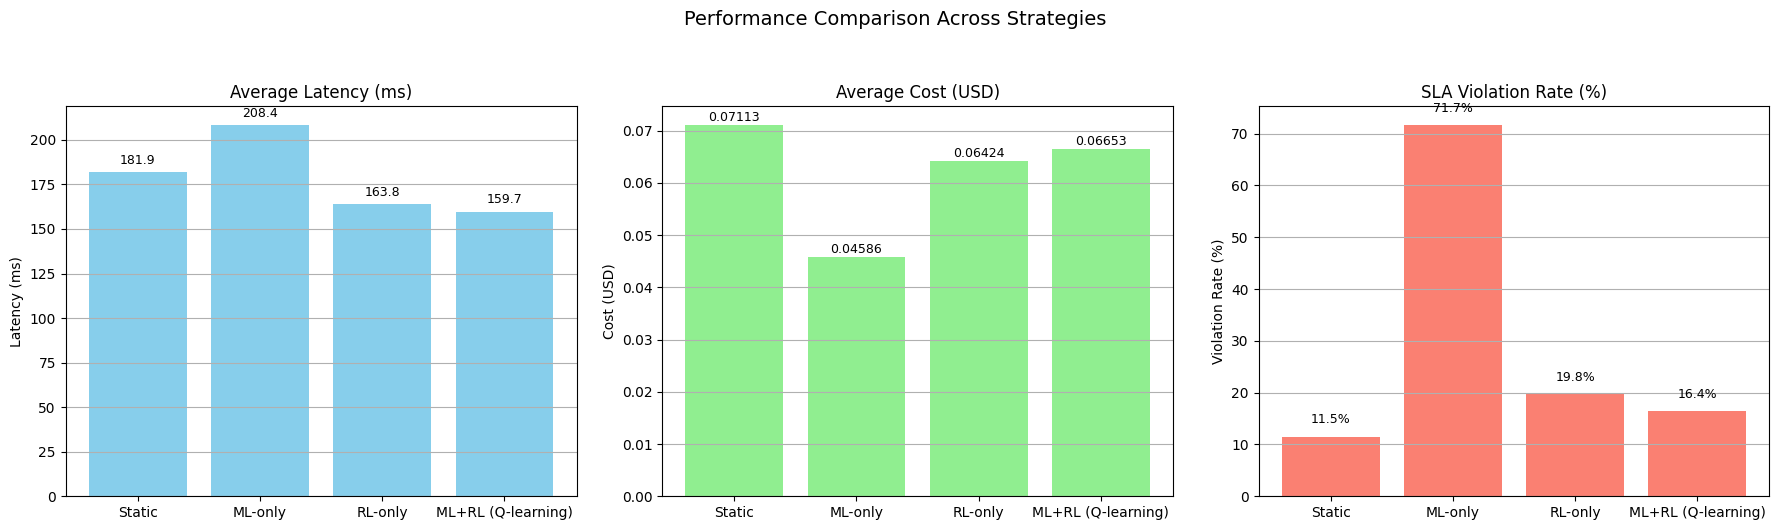

In [48]:
# =========================================================================
# Section 6: Baseline Strategy Evaluation (Static, ML-only, RL-only, ML+RL)
# =========================================================================

# --- Define strategy evaluation function ---
def evaluate_strategy(env, strategy='ml+rl', agent=None, fixed_action=None):
    """
    Run one episode in `env` following the given `strategy`.
    Returns a DataFrame of step-by-step metrics (forecast, config, latency, cost, reward, SLA).
    """
    logs = []
    state, _ = env.reset()
    done = False
    step = 0

    while not done:
        # choose action according to static, ML heuristic, RL policy, or hybrid
        if strategy == 'static':
            action = fixed_action
        elif strategy == 'ml-only':
            forecast = env.forecast_sequence[env.current_step] / env.max_forecast
            if forecast > 0.75:
                action = 15
            elif forecast > 0.5:
                action = 10
            else:
                action = 0
        elif strategy == 'rl-only':
            # update env.state with forecast then sample from Q-learning agent
            forecast = env.forecast_sequence[env.current_step] / env.max_forecast
            env.state[0] = forecast
            action = agent.choose_action(env.state)
        elif strategy == 'ml+rl':
             # use learned agent policy directly
            action = agent.choose_action(state)
        else:
            raise ValueError("Unknown strategy")

        # step the environment and record outcomes
        next_state, reward, done, _, _ = env.step(action)
        memory, timeout, concurrency = env._decode_action(action)
        latency = next_state[1] * 300
        cost = next_state[2] * 0.1
        forecast_val = next_state[0] * env.max_forecast
        logs.append({
            "step": step,
            "forecast": forecast_val,
            "memory": memory,
            "timeout": timeout,
            "concurrency": concurrency,
            "latency": latency,
            "cost": cost,
            "reward": reward,
            "sla_violated": latency > 200
        })
        state = next_state
        step += 1

    return pd.DataFrame(logs)

# Re-instantiate fresh environments to avoid contamination
env_static = ServerlessTuningEnv(forecast_sequence=forecast_series)
env_mlonly = ServerlessTuningEnv(forecast_sequence=forecast_series)
env_rlonly = ServerlessTuningEnv(forecast_sequence=forecast_series)
env_hybrid = ServerlessTuningEnv(forecast_sequence=forecast_series)

# Fixed action index: corresponds to (memory=512, timeout=5, concurrency=1)
fixed_action_idx = 4

# Evaluate each strategy
df_static = evaluate_strategy(env_static, strategy='static', fixed_action=fixed_action_idx)
df_mlonly = evaluate_strategy(env_mlonly, strategy='ml-only')
df_rlonly = evaluate_strategy(env_rlonly, strategy='rl-only', agent=agent)
df_hybrid = evaluate_strategy(env_hybrid, strategy='ml+rl', agent=agent)

# Print summary stats
def summarize(df, label):
    """
    Print average latency, cost, and SLA violation rate for a strategy DataFrame.
    """
    avg_latency = df["latency"].mean()
    avg_cost = df["cost"].mean()
    sla_rate = df["sla_violated"].mean() * 100
    print(f"--- {label} ---")
    print(f"Average Latency: {avg_latency:.2f} ms")
    print(f"Average Cost: ${avg_cost:.6f}")
    print(f"SLA Violation Rate: {sla_rate:.2f}%\n")

# Print summary statistics for each strategy
summarize(df_static, "Static Baseline")
summarize(df_mlonly, "ML-only Baseline")
summarize(df_rlonly, "RL-only Baseline")
summarize(df_hybrid, "ML + RL (Hybrid)")

# Save detailed logs for later analysis
df_static.to_csv("baseline_static.csv", index=False)
df_mlonly.to_csv("baseline_ml_only.csv", index=False)
df_rlonly.to_csv("baseline_rl_only.csv", index=False)
df_hybrid.to_csv("baseline_hybrid.csv", index=False)

# Plot comparison of latency, cost, and SLA violation rate
import matplotlib.pyplot as plt

strategies = ["Static", "ML-only", "RL-only", "ML+RL (Q-learning)"]

avg_latencies = [
    df_static["latency"].mean(),
    df_mlonly["latency"].mean(),
    df_rlonly["latency"].mean(),
    df_hybrid["latency"].mean()
]

avg_costs = [
    df_static["cost"].mean(),
    df_mlonly["cost"].mean(),
    df_rlonly["cost"].mean(),
    df_hybrid["cost"].mean()
]

sla_violations = [
    df_static["sla_violated"].mean() * 100,
    df_mlonly["sla_violated"].mean() * 100,
    df_rlonly["sla_violated"].mean() * 100,
    df_hybrid["sla_violated"].mean() * 100
]

# Set up subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Chart 1: Latency
axs[0].bar(strategies, avg_latencies, color='skyblue')
axs[0].set_title("Average Latency (ms)")
axs[0].set_ylabel("Latency (ms)")
axs[0].grid(axis='y')
for i, val in enumerate(avg_latencies):
    axs[0].text(i, val + 3, f"{val:.1f}", ha='center', va='bottom', fontsize=9)

# Chart 2: Cost
axs[1].bar(strategies, avg_costs, color='lightgreen')
axs[1].set_title("Average Cost (USD)")
axs[1].set_ylabel("Cost (USD)")
axs[1].grid(axis='y')
for i, val in enumerate(avg_costs):
    axs[1].text(i, val + 0.0001, f"{val:.5f}", ha='center', va='bottom', fontsize=9)

# Chart 3: SLA Violation Rate
axs[2].bar(strategies, sla_violations, color='salmon')
axs[2].set_title("SLA Violation Rate (%)")
axs[2].set_ylabel("Violation Rate (%)")
axs[2].grid(axis='y')
for i, val in enumerate(sla_violations):
    axs[2].text(i, val + 2, f"{val:.1f}%", ha='center', va='bottom', fontsize=9)

plt.suptitle("Performance Comparison Across Strategies", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


--- Static Baseline (A2C) ---
Average Latency: 181.89 ms
Average Cost: $0.071125
SLA Violation Rate: 11.53%

--- ML-only Baseline (A2C) ---
Average Latency: 208.41 ms
Average Cost: $0.045863
SLA Violation Rate: 71.70%

--- RL-only Baseline (A2C) ---
Average Latency: 155.09 ms
Average Cost: $0.100000
SLA Violation Rate: 6.21%

--- ML + RL (Hybrid) (A2C) ---
Average Latency: 118.60 ms
Average Cost: $0.090639
SLA Violation Rate: 5.47%



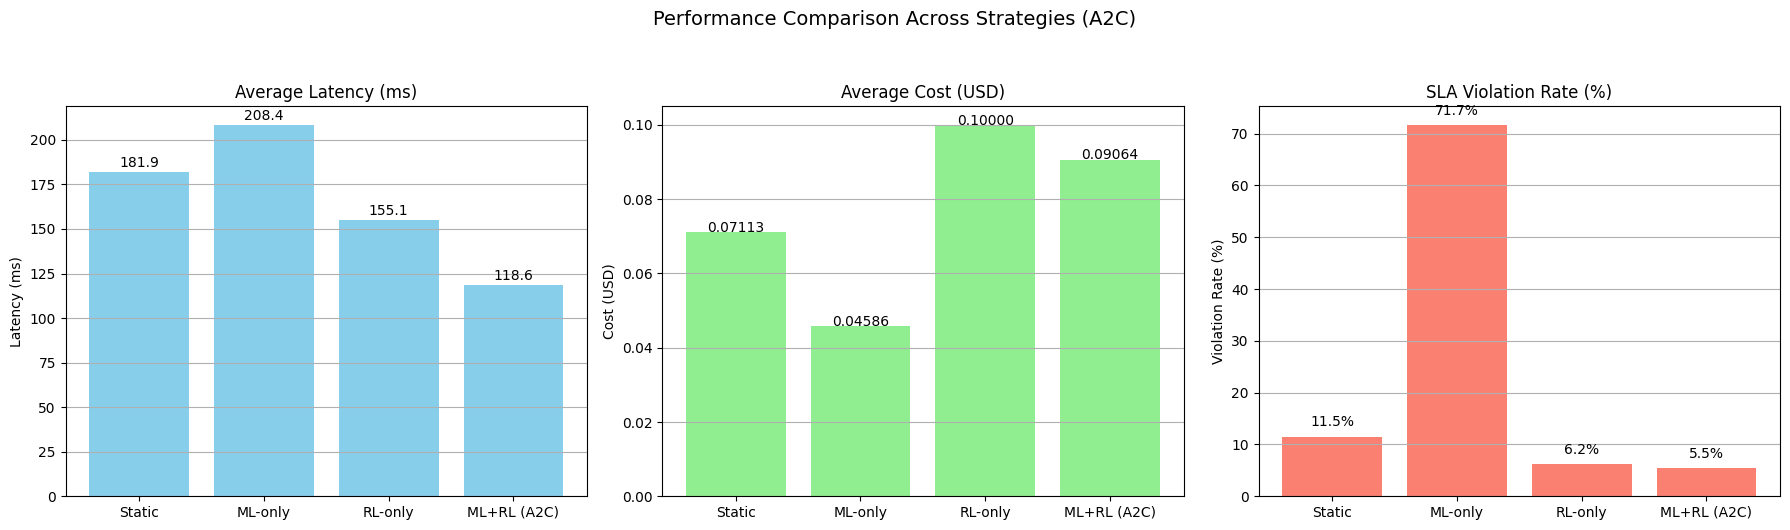

In [61]:
# ===============================================================
# Section 6A: Baseline Strategy Evaluation using A2C Agent
# ===============================================================

def evaluate_strategy_a2c(env, strategy='ml+rl', fixed_action=None):
    """Run one episode with the given strategy and return step logs."""
    logs = []
    state, _ = env.reset()
    done = False
    step = 0

    while not done:
        forecast = env.forecast_sequence[env.current_step] / env.max_forecast

        if strategy == 'static':
            action = fixed_action

        elif strategy == 'ml-only':
            if forecast > 0.75:
                action = 15  # Max provision
            elif forecast > 0.5:
                action = 10  # Medium provision
            else:
                action = 0   # Low provision

        elif strategy == 'rl-only':
            dynamic_state = state + np.random.uniform(-0.05, 0.05, size=3)
            dynamic_state = np.clip(dynamic_state, 0, 1)
            action, _ = a2c_model.predict(dynamic_state, deterministic=True)

        elif strategy == 'ml+rl':
            forecast = env.forecast_sequence[env.current_step] / env.max_forecast
            state[0] = forecast
            action, _ = a2c_model.predict(state, deterministic=True)
            memory, timeout, concurrency = env._decode_action(action)

            # Track latency trend
            if len(logs) >= 3:
                recent_latencies = [log["latency"] for log in logs[-3:]]
                avg_recent_latency = sum(recent_latencies) / 3
            else:
                avg_recent_latency = 200  # default conservative

            # Rule 1: If latency is low and concurrency is high → downscale to save cost
            if avg_recent_latency < 150 and concurrency > 1:
                action = max(action - 1, 0)

            # Rule 2: If latency > 220ms or forecast > 0.85 → upscale
            elif avg_recent_latency > 220 or forecast > 0.85:
                if concurrency < 2:
                    action = min(action + 1, env.action_space.n - 1)

            # Rule 3: If recent cost is too high while latency is OK → reduce action
            if len(logs) >= 5:
                recent_costs = [log["cost"] for log in logs[-5:]]
                if np.mean(recent_costs) > 0.09 and avg_recent_latency < 200:
                    action = max(action - 1, 0)

        else:
            raise ValueError("Unknown strategy")

        next_state, reward, done, _, _ = env.step(action)
        memory, timeout, concurrency = env._decode_action(action)
        latency = next_state[1] * 300
        cost = next_state[2] * 0.1
        forecast_val = next_state[0] * env.max_forecast

        logs.append({
            "step": step,
            "forecast": forecast_val,
            "memory": memory,
            "timeout": timeout,
            "concurrency": concurrency,
            "latency": latency,
            "cost": cost,
            "reward": reward,
            "sla_violated": latency > 200
        })

        state = next_state
        step += 1

    return pd.DataFrame(logs)

# Load trained A2C model
from stable_baselines3 import A2C
a2c_model = A2C.load("a2c_serverless_model")

# Fresh environments for fair comparison
env_static_a2c = ServerlessTuningEnv(forecast_sequence=forecast_series)
env_mlonly_a2c = ServerlessTuningEnv(forecast_sequence=forecast_series)
env_rlonly_a2c = ServerlessTuningEnv(forecast_sequence=forecast_series)
env_hybrid_a2c = ServerlessTuningEnv(forecast_sequence=forecast_series)

# Evaluate all strategies
fixed_action_idx = 4
df_static_a2c = evaluate_strategy_a2c(env_static_a2c, strategy='static', fixed_action=fixed_action_idx)
df_mlonly_a2c = evaluate_strategy_a2c(env_mlonly_a2c, strategy='ml-only')
df_rlonly_a2c = evaluate_strategy_a2c(env_rlonly_a2c, strategy='rl-only')
df_hybrid_a2c = evaluate_strategy_a2c(env_hybrid_a2c, strategy='ml+rl')

# Summary print
def summarize_a2c(df, label):
    """Print average latency, cost, and SLA violation rate."""
    avg_latency = df["latency"].mean()
    avg_cost = df["cost"].mean()
    sla_rate = df["sla_violated"].mean() * 100
    print(f"--- {label} (A2C) ---")
    print(f"Average Latency: {avg_latency:.2f} ms")
    print(f"Average Cost: ${avg_cost:.6f}")
    print(f"SLA Violation Rate: {sla_rate:.2f}%\n")

summarize_a2c(df_static_a2c, "Static Baseline")
summarize_a2c(df_mlonly_a2c, "ML-only Baseline")
summarize_a2c(df_rlonly_a2c, "RL-only Baseline")
summarize_a2c(df_hybrid_a2c, "ML + RL (Hybrid)")

# Save detailed logs for later analysis
df_static_a2c.to_csv("baseline_static_a2c.csv", index=False)
df_mlonly_a2c.to_csv("baseline_ml_only_a2c.csv", index=False)
df_rlonly_a2c.to_csv("baseline_rl_only_a2c.csv", index=False)
df_hybrid_a2c.to_csv("baseline_hybrid_a2c.csv", index=False)

# Plot comparison charts
import matplotlib.pyplot as plt

strategies_a2c = ["Static", "ML-only", "RL-only", "ML+RL (A2C)"]
avg_latencies_a2c = [
    df_static_a2c["latency"].mean(),
    df_mlonly_a2c["latency"].mean(),
    df_rlonly_a2c["latency"].mean(),
    df_hybrid_a2c["latency"].mean()
]
avg_costs_a2c = [
    df_static_a2c["cost"].mean(),
    df_mlonly_a2c["cost"].mean(),
    df_rlonly_a2c["cost"].mean(),
    df_hybrid_a2c["cost"].mean()
]
sla_violations_a2c = [
    df_static_a2c["sla_violated"].mean() * 100,
    df_mlonly_a2c["sla_violated"].mean() * 100,
    df_rlonly_a2c["sla_violated"].mean() * 100,
    df_hybrid_a2c["sla_violated"].mean() * 100
]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Chart 1 - Latency chart
axs[0].bar(strategies_a2c, avg_latencies_a2c, color='skyblue')
axs[0].set_title("Average Latency (ms)")
axs[0].set_ylabel("Latency (ms)")
axs[0].grid(axis='y')
for i, val in enumerate(avg_latencies_a2c):
    axs[0].text(i, val + 3, f"{val:.1f}", ha='center')

# Chart 2 - Cost chart
axs[1].bar(strategies_a2c, avg_costs_a2c, color='lightgreen')
axs[1].set_title("Average Cost (USD)")
axs[1].set_ylabel("Cost (USD)")
axs[1].grid(axis='y')
for i, val in enumerate(avg_costs_a2c):
    axs[1].text(i, val + 0.0001, f"{val:.5f}", ha='center')

# Chart 3 - SLA chart
axs[2].bar(strategies_a2c, sla_violations_a2c, color='salmon')
axs[2].set_title("SLA Violation Rate (%)")
axs[2].set_ylabel("Violation Rate (%)")
axs[2].grid(axis='y')
for i, val in enumerate(sla_violations_a2c):
    axs[2].text(i, val + 2, f"{val:.1f}%", ha='center')

plt.suptitle("Performance Comparison Across Strategies (A2C)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


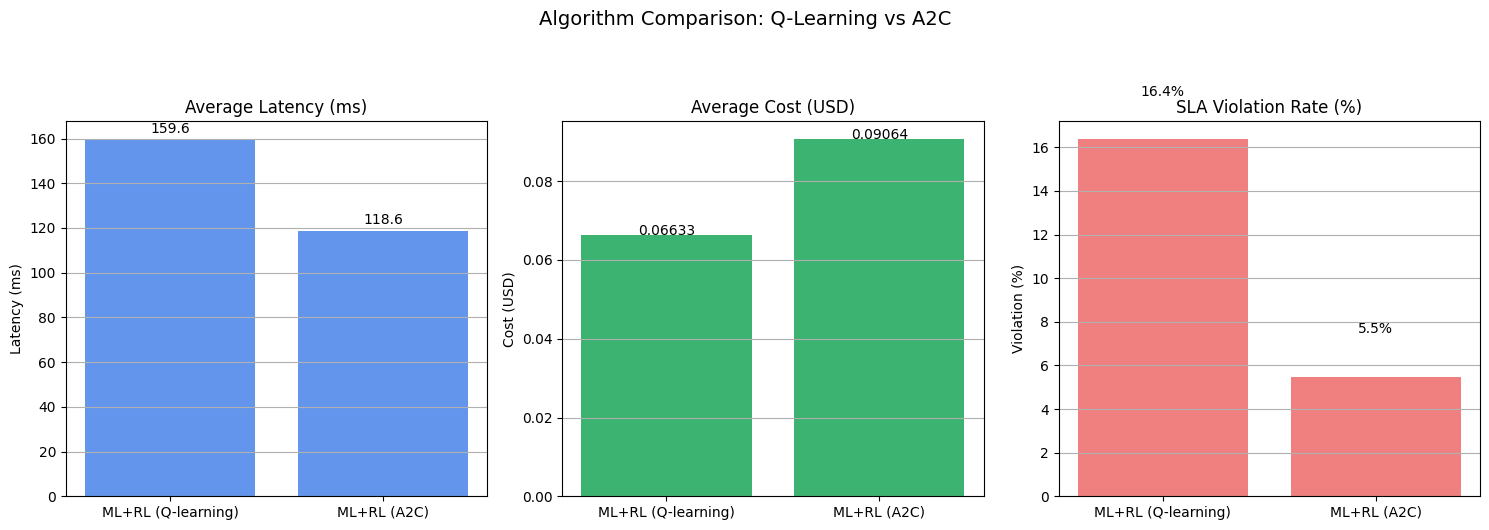

In [45]:
# ========================================
# Algorithm Comparison: Q-Learning vs A2C
# ========================================

# Labels for comparison
strategy_labels = ["ML+RL (Q-learning)", "ML+RL (A2C)"]

# Extract metrics
latency_values = [
    df_hybrid["latency"].mean(),
    df_hybrid_a2c["latency"].mean()
]

cost_values = [
    df_hybrid["cost"].mean(),
    df_hybrid_a2c["cost"].mean()
]

sla_values = [
    df_hybrid["sla_violated"].mean() * 100,
    df_hybrid_a2c["sla_violated"].mean() * 100
]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Chart 1 - Latency Plot
axs[0].bar(strategy_labels, latency_values, color='cornflowerblue')
axs[0].set_title("Average Latency (ms)")
axs[0].set_ylabel("Latency (ms)")
axs[0].grid(axis='y')
for i, val in enumerate(latency_values):
    axs[0].text(i, val + 3, f"{val:.1f}", ha='center', fontsize=10)

# Chart 2 - Cost Plot
axs[1].bar(strategy_labels, cost_values, color='mediumseagreen')
axs[1].set_title("Average Cost (USD)")
axs[1].set_ylabel("Cost (USD)")
axs[1].grid(axis='y')
for i, val in enumerate(cost_values):
    axs[1].text(i, val + 0.0001, f"{val:.5f}", ha='center', fontsize=10)

# Chart 3 - SLA Violation Plot
axs[2].bar(strategy_labels, sla_values, color='lightcoral')
axs[2].set_title("SLA Violation Rate (%)")
axs[2].set_ylabel("Violation (%)")
axs[2].grid(axis='y')
for i, val in enumerate(sla_values):
    axs[2].text(i, val + 2, f"{val:.1f}%", ha='center', fontsize=10)

plt.suptitle("Algorithm Comparison: Q-Learning vs A2C", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


--- Bursty Traffic ---
Average Latency: 163.95 ms
Average Cost: $0.273420
SLA Violation Rate: 6.80%

--- Periodic Traffic ---
Average Latency: 161.16 ms
Average Cost: $0.265897
SLA Violation Rate: 5.07%

--- Irregular Traffic ---
Average Latency: 170.71 ms
Average Cost: $0.230194
SLA Violation Rate: 27.12%



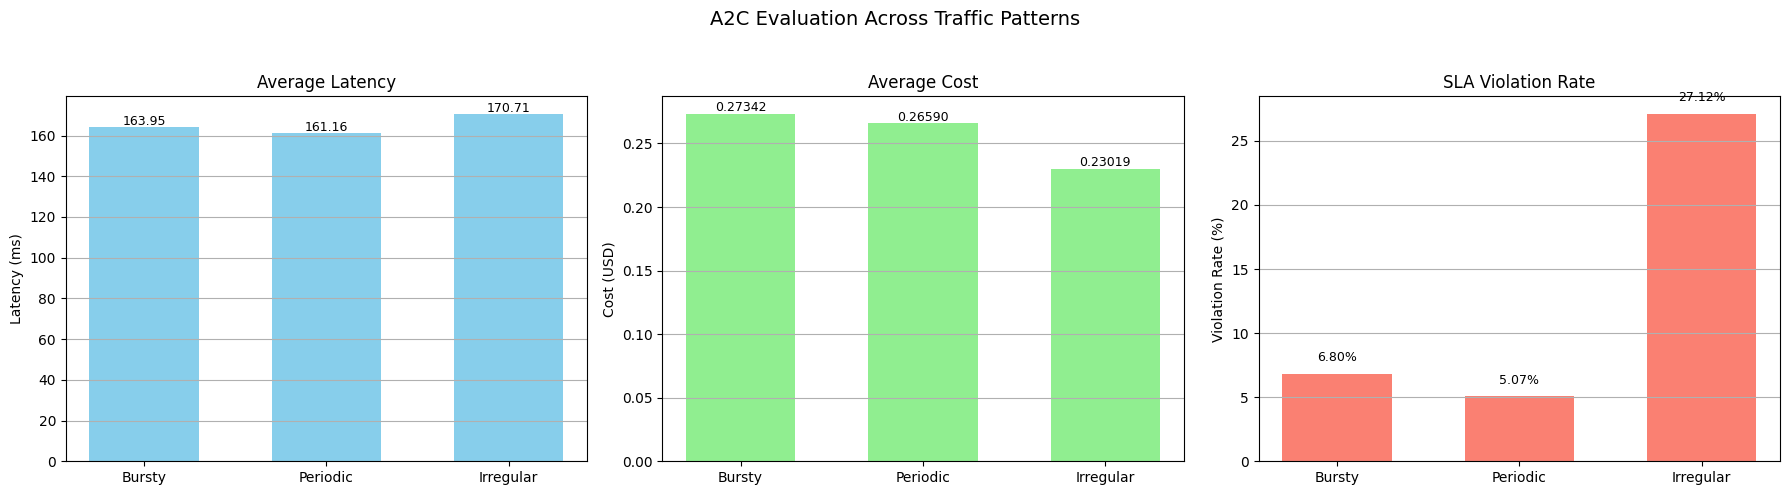

In [54]:
# =================================================================
# Section 7: Multi-Traffic Evaluation (Bursty, Periodic, Irregular)
# =================================================================

from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Load trained A2C model
a2c_model = A2C.load("a2c_serverless_model")

# Enhanced traffic pattern generator with realistic variation
def generate_traffic(pattern, total_points):
    base = 100
    if pattern == "bursty":
        return [int(base + (np.sin(i / 15.0) * 60 + (i % 20) * 10 + np.random.normal(0, 10))) for i in range(total_points)]
    elif pattern == "periodic":
        return [int(base + np.cos(i / 10.0) * 50 + 30 * np.sin(i / 30.0) + np.random.normal(0, 10)) for i in range(total_points)]
    elif pattern == "irregular":
        return [int(base + random.randint(-120, 180)) for i in range(total_points)]
    else:
        raise ValueError("Invalid traffic pattern")

# Evaluation function
def evaluate_with_a2c(forecast_seq, model):
    env = DummyVecEnv([lambda: ServerlessTuningEnv(forecast_seq)])
    obs = env.reset()
    done = False

    latency_list = []
    cost_list = []
    sla_violations = 0
    total_steps = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)

        latency = info[0]["latency"]
        cost = info[0]["cost"]
        violated = info[0]["sla_violated"]

        latency_list.append(latency)
        cost_list.append(cost)
        sla_violations += int(violated)
        total_steps += 1

    return pd.DataFrame({
        "Avg_Latency": [np.mean(latency_list)],
        "Avg_Cost": [np.mean(cost_list)],
        "SLA_Violation": [sla_violations / total_steps * 100]
    })

# Generate traffic
total_points = len(forecast_series)
traffic_bursty = generate_traffic("bursty", total_points)
traffic_periodic = generate_traffic("periodic", total_points)
traffic_irregular = generate_traffic("irregular", total_points)

# Evaluate A2C on all patterns
df_bursty = evaluate_with_a2c(traffic_bursty, a2c_model)
df_periodic = evaluate_with_a2c(traffic_periodic, a2c_model)
df_irregular = evaluate_with_a2c(traffic_irregular, a2c_model)

# Summary print
def summarize(df, label):
    print(f"--- {label} ---")
    print(f"Average Latency: {df['Avg_Latency'].mean():.2f} ms")
    print(f"Average Cost: ${df['Avg_Cost'].mean():.6f}")
    print(f"SLA Violation Rate: {df['SLA_Violation'].mean():.2f}%\n")

summarize(df_bursty, "Bursty Traffic")
summarize(df_periodic, "Periodic Traffic")
summarize(df_irregular, "Irregular Traffic")

# Visualization
patterns = ["Bursty", "Periodic", "Irregular"]
latencies = [df_bursty["Avg_Latency"].mean(), df_periodic["Avg_Latency"].mean(), df_irregular["Avg_Latency"].mean()]
costs = [df_bursty["Avg_Cost"].mean(), df_periodic["Avg_Cost"].mean(), df_irregular["Avg_Cost"].mean()]
violations = [df_bursty["SLA_Violation"].mean(), df_periodic["SLA_Violation"].mean(), df_irregular["SLA_Violation"].mean()]

x = np.arange(len(patterns))

# Subplots in one row
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
bar_width = 0.6

# Latency subplot
axs[0].bar(x, latencies, color='skyblue', width=bar_width)
axs[0].set_xticks(x)
axs[0].set_xticklabels(patterns)
axs[0].set_ylabel("Latency (ms)")
axs[0].set_title("Average Latency")
axs[0].grid(axis='y')
for i, val in enumerate(latencies):
    axs[0].text(i, val + 1, f"{val:.2f}", ha='center', fontsize=9)

# Cost subplot
axs[1].bar(x, costs, color='lightgreen', width=bar_width)
axs[1].set_xticks(x)
axs[1].set_xticklabels(patterns)
axs[1].set_ylabel("Cost (USD)")
axs[1].set_title("Average Cost")
axs[1].grid(axis='y')
for i, val in enumerate(costs):
    axs[1].text(i, val + 0.002, f"{val:.5f}", ha='center', fontsize=9)

# SLA Violation subplot
axs[2].bar(x, violations, color='salmon', width=bar_width)
axs[2].set_xticks(x)
axs[2].set_xticklabels(patterns)
axs[2].set_ylabel("Violation Rate (%)")
axs[2].set_title("SLA Violation Rate")
axs[2].grid(axis='y')
for i, val in enumerate(violations):
    axs[2].text(i, val + 1, f"{val:.2f}%", ha='center', fontsize=9)

# Overall layout
fig.suptitle("A2C Evaluation Across Traffic Patterns", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


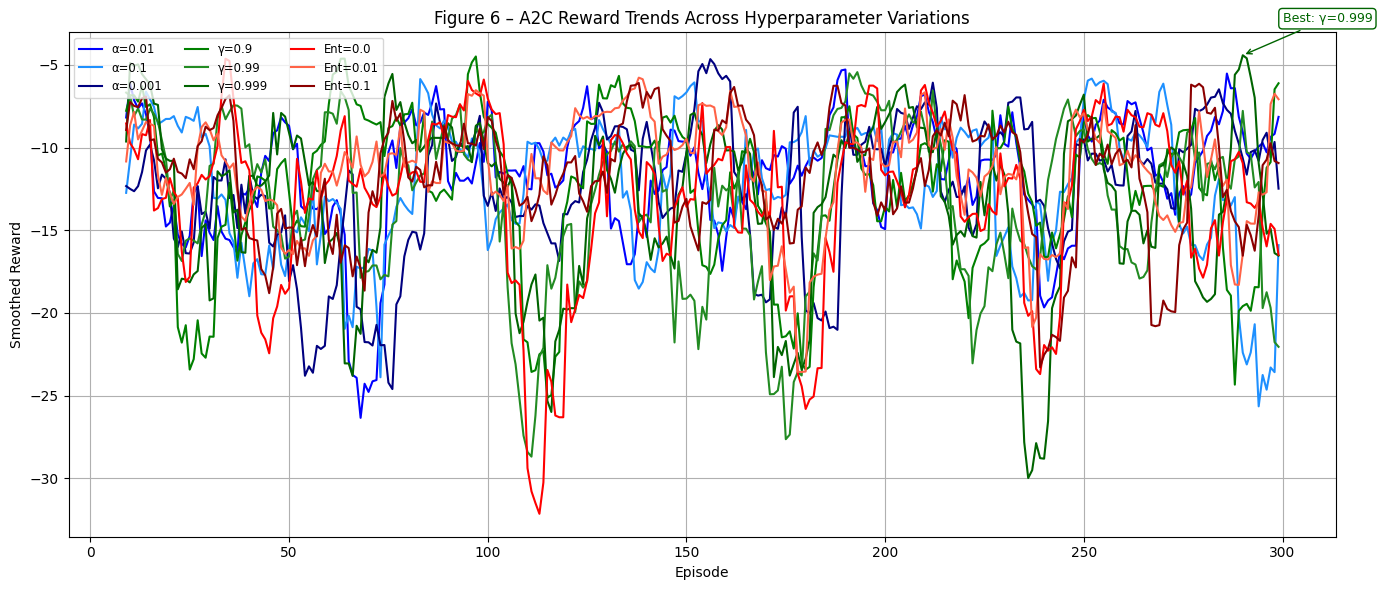

In [58]:
# ==================================================
# Section 8: A2C Hyperparameter Sensitivity Analysis
# ==================================================

import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

# --- Define the experiment function ---
def train_a2c_with_params(forecast_series, learning_rate, gamma, ent_coef, label):
    env = DummyVecEnv([lambda: ServerlessTuningEnv(forecast_series)])
    model = A2C("MlpPolicy", env, learning_rate=learning_rate, gamma=gamma,
                ent_coef=ent_coef, verbose=0)

    rewards = []
    obs = env.reset()
    for _ in range(300):
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        rewards.append(reward[0])
    return rewards, label

# --- Define hyperparameter configurations ---
param_configs = [
    {"learning_rate": 0.01, "gamma": 0.99,  "ent_coef": 0.01, "label": "α=0.01",  "color": "blue"},
    {"learning_rate": 0.1,  "gamma": 0.99,  "ent_coef": 0.01, "label": "α=0.1",   "color": "dodgerblue"},
    {"learning_rate": 0.001,"gamma": 0.99,  "ent_coef": 0.01, "label": "α=0.001", "color": "navy"},

    {"learning_rate": 0.01, "gamma": 0.9,   "ent_coef": 0.01, "label": "γ=0.9",   "color": "green"},
    {"learning_rate": 0.01, "gamma": 0.99,  "ent_coef": 0.01, "label": "γ=0.99",  "color": "forestgreen"},
    {"learning_rate": 0.01, "gamma": 0.999, "ent_coef": 0.01, "label": "γ=0.999", "color": "darkgreen"},

    {"learning_rate": 0.01, "gamma": 0.99,  "ent_coef": 0.0,  "label": "Ent=0.0", "color": "red"},
    {"learning_rate": 0.01, "gamma": 0.99,  "ent_coef": 0.01, "label": "Ent=0.01","color": "tomato"},
    {"learning_rate": 0.01, "gamma": 0.99,  "ent_coef": 0.1,  "label": "Ent=0.1", "color": "darkred"},
]

# --- Run experiments ---
results = []
for config in param_configs:
    # Extract only the required keys for training
    train_args = {k: config[k] for k in ['learning_rate', 'gamma', 'ent_coef', 'label']}

    # Train and collect results
    rewards, label = train_a2c_with_params(forecast_series, **train_args)
    smoothed = pd.Series(rewards).rolling(window=10).mean()

    results.append((smoothed, label, config["color"]))

# --- Plot results ---
plt.figure(figsize=(14, 6))

# Track best config info
best_value = float('-inf')
best_ep = -1
best_label = ''
best_color = ''

for smoothed, label, color in results:
    plt.plot(smoothed, label=label, color=color)

    # Check max reward value in this line
    max_val = smoothed.max()
    max_ep = smoothed.idxmax()

    if max_val > best_value:
        best_value = max_val
        best_ep = max_ep
        best_label = label
        best_color = color

# Annotate the best config
plt.annotate(
    f"Best: {best_label}",
    xy=(best_ep, best_value),
    xytext=(best_ep + 10, best_value + 2),
    color=best_color,
    arrowprops=dict(arrowstyle="->", color=best_color),
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor=best_color)
)

plt.title("A2C Reward Trends Across Hyperparameter Variations")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.legend(loc='upper left', ncol=3, fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()



In [59]:
# ============================================
# Section 9: Cost–Latency Trade-off Simulation
# ============================================

from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

# --- Custom environment prioritizing cost ---
class CostPriorityEnv(ServerlessTuningEnv):
    def step(self, action):
        # Decode action to get actual configuration
        memory, timeout, concurrency = self._decode_action(action)

        # Simulate latency: inverse relation with memory and concurrency
        latency = max(100, 300 - memory / 16 - concurrency * 10)

        # Simulate cost: function of memory, timeout, concurrency
        cost = (memory / 1024) * timeout * concurrency * 0.002  # Adjust unit price as needed

        # SLA violation threshold
        sla_violated = latency > 200

        # Forecast for this step
        forecast = self.forecast_sequence[self.current_step]
        normalized_forecast = forecast / self.max_forecast

        # Normalize for state space
        normalized_latency = latency / 300
        normalized_cost = cost / 0.1  # assuming 0.1 is upper bound

        self.state = np.array([normalized_forecast, normalized_latency, normalized_cost])

        # Reward prioritizes cost, slightly penalizes latency
        reward = - (0.7 * cost + 0.3 * latency / 300)

        self.current_step += 1
        done = self.current_step >= len(self.forecast_sequence)

        return self.state, reward, done, False, {}

# --- Train A2C in cost-prioritized environment ---
cost_env = DummyVecEnv([lambda: CostPriorityEnv(forecast_series)])
cost_model = A2C("MlpPolicy", cost_env, verbose=0)
cost_model.learn(total_timesteps=10_000)

# --- Evaluate the cost-prioritized agent ---
def evaluate_cost_model(model, forecast_seq):
    env = CostPriorityEnv(forecast_seq)
    vec_env = DummyVecEnv([lambda: env])
    obs = vec_env.reset()

    logs = []
    done = False
    step = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        next_obs, reward, done, info = vec_env.step(action)
        scalar_action = int(action[0]) if isinstance(action, np.ndarray) else int(action)
        memory, timeout, concurrency = env._decode_action(scalar_action)

        latency = next_obs[0][1] * 300
        cost = next_obs[0][2] * 0.1
        forecast_val = forecast_seq[min(step, len(forecast_seq)-1)]
        logs.append({
            "step": step,
            "forecast": forecast_val,
            "memory": memory,
            "timeout": timeout,
            "concurrency": concurrency,
            "latency": latency,
            "cost": cost,
            "reward": reward[0],
            "sla_violated": latency > 200
        })
        obs = next_obs
        step += 1

    return pd.DataFrame(logs)

df_cost_priority = evaluate_cost_model(cost_model, forecast_series)

# --- Evaluate original A2C agent for comparison ---
df_a2c_default = evaluate_strategy_a2c(
    env=ServerlessTuningEnv(forecast_sequence=forecast_series),
    strategy='ml+rl'
)

# --- Summary print ---
def summarize(df, label):
    print(f"--- {label} ---")
    print(f"Avg Latency: {df['latency'].mean():.2f} ms")
    print(f"Avg Cost: ${df['cost'].mean():.6f}")
    print(f"SLA Violation Rate: {df['sla_violated'].mean() * 100:.2f}%\n")

summarize(df_a2c_default, "Original A2C")
summarize(df_cost_priority, "Cost-Prioritized A2C")

--- Original A2C ---
Avg Latency: 118.60 ms
Avg Cost: $0.090639
SLA Violation Rate: 5.47%

--- Cost-Prioritized A2C ---
Avg Latency: 205.99 ms
Avg Cost: $0.018004
SLA Violation Rate: 99.99%



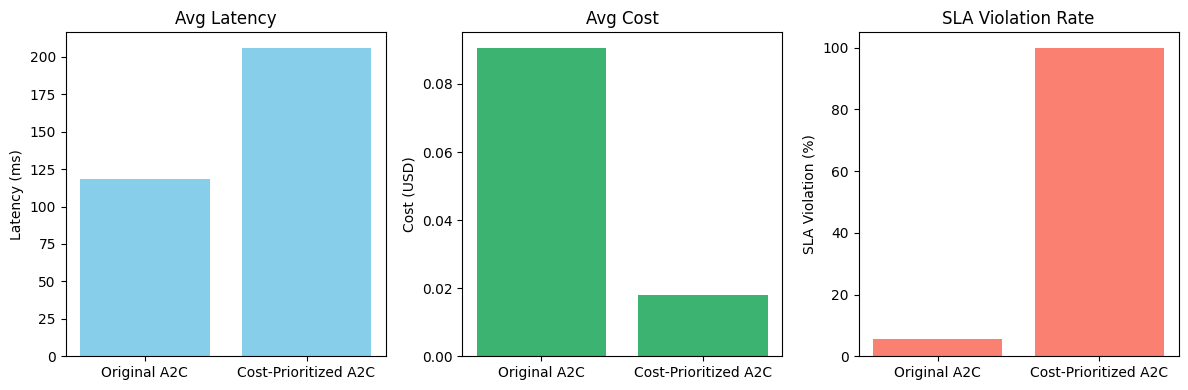

In [60]:
# --- Plot comparison ---
import matplotlib.pyplot as plt

models = ["Original A2C", "Cost-Prioritized A2C"]

plt.figure(figsize=(12, 4))

# For latency chart
plt.subplot(1, 3, 1)
plt.bar(models, [df_a2c_default["latency"].mean(), df_cost_priority["latency"].mean()], color='skyblue')
plt.ylabel("Latency (ms)")
plt.title("Avg Latency")

# For Cost chart
plt.subplot(1, 3, 2)
plt.bar(models, [df_a2c_default["cost"].mean(), df_cost_priority["cost"].mean()], color='mediumseagreen')
plt.ylabel("Cost (USD)")
plt.title("Avg Cost")

# For SLA chart
plt.subplot(1, 3, 3)
plt.bar(models, [df_a2c_default["sla_violated"].mean()*100, df_cost_priority["sla_violated"].mean()*100], color='salmon')
plt.ylabel("SLA Violation (%)")
plt.title("SLA Violation Rate")

plt.tight_layout()
plt.show()
